In [1]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,Conv2DTranspose,BatchNormalization,LSTM,TimeDistributed,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.metrics import Mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import librosa as lr
from PIL import Image
import os
import cv2
import moviepy.editor as mpy
from gtts import gTTS

In [3]:
class gen_preproc:

    def __init__(self):
        self.fake_data = []

    def generator(self,gen_weights_path):
        self.gen = self.build_generator()
        self.gen.load_weights(gen_weights_path)

    def gen_data(self,audio_path,image_path):
        audio,sr = lr.load(audio_path,sr=76800)
        audio += 0.2 * tf.random.uniform(tf.shape(audio))
        audio = np.array(audio)
        audio1 = (audio - (audio.min())) / (audio.max() - (audio.min())) * (1 - (-1)) + (-1)
        num_images = int(len(audio)/3072)
        start = 0
        iterator_value = 3072
        end = 3072
        fake_image = Image.open(image_path)
        fake_image = fake_image.resize((32,32)) #previous: 64,64
        fake_image = np.array(fake_image)
        fake_image = fake_image.flatten()
        fake_image = (fake_image-127.5)/127.5
        positional_encoding = self.get_positional_encoding(num_images)
        for i in range(num_images):
            f_data = fake_image+audio[start:end]
            f_data = np.append(f_data,positional_encoding[i])
            self.fake_data.append(f_data)
            start += iterator_value
            end += iterator_value
        self.fake_data = np.array(self.fake_data)
        return self.fake_data

    def get_positional_encoding(self,max_len):
        d_model = 882
        pos_enc = np.zeros((max_len, d_model))
        for pos in range(max_len):
            for i in range(d_model):
                if i % 2 == 0:
                    pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
                    # print("i%2 == 0 : "+str(pos)+" : "+str(i)+" : "+str(np.sin(pos / (10000 ** (i / d_model)))))
                else:
                    pos_enc[pos, i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))
                    # print("i%2 != 0 :"+str(pos)+" : "+str(i)+" : "+ str(np.cos(pos / (10000 ** ((i -1) / d_model)))))
        return pos_enc
    
    def build_generator(self):
        model = Sequential()

        # Takes in random values and reshapes it to 7x7x128
        # Beginnings of a generated image
        model.add(Dense(8 * 8 * 64, input_dim=3954))
        # input_dim 3954 before positional encoding and after 4096 note: check the model weights in mb prev: 17151971 (65.43 MB) new: 17733603 (67.65 MB)
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        # convert 1d to 3d
        model.add(Reshape((8, 8, 64)))

        # upsample to 32x32
        model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        # upsample to 32x32
        model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        # upsample to 64x64
        model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2D(32, (4, 4), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
        #model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2D(3, (4, 4), padding='same', activation='tanh'))

        return model
    
    def gen_images(self,text,image_path,video_path):
        self.audio_from_text(text=text,audio_path=video_path)
        self.gen_data(audio_path=video_path+"/sa1.mp3",image_path=image_path)
        n = 1
        for i in self.fake_data:
            noise = i[np.newaxis,:]
            g_img1 = self.gen(noise)
            g_img = (g_img1 * 127.5) + 127.5
            # img_g.append(np.array(g_img[0]))
            g_img.numpy()
            img = array_to_img(g_img[0])
            plt.imshow(img)
            plt.axis('off')
            plt.savefig(video_path+f'/img_{n}.png')
            n += 1
        
        frame = cv2.imread(video_path+'/img_1.png')
        size = list(frame.shape)
        del size[2]
        size.reverse()
        print(size)
        output_video_name = video_path+'/g_video.mp4'
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_name, fourcc,25,size)
        m= 1
        for dim in self.fake_data:
            i = video_path+"/img_"+str(m)+".png"
            # print(i)
            out.write(cv2.imread(i))
            os.remove(i)
            m += 1
        out.release()

        video = mpy.VideoFileClip(video_path+"/g_video.mp4")
        audio = mpy.AudioFileClip(video_path+"/sa1.mp3")

        audio1 = mpy.CompositeAudioClip([audio])
        video1 = video.set_audio(audio1)
        video1.write_videofile(video_path+"/vid.mp4",fps=25)

        os.remove(video_path+"/g_video.mp4")


    def audio_from_text(self,audio_path,text):
        language = "en"
        speech = gTTS(text,lang=language,tld="com.au",slow=True)
        speech.save(audio_path+"/sa1.mp3")




In [4]:
data = gen_preproc()

In [5]:
# generator weights paths
data.generator(gen_weights_path="/ml/ml_proj_ex/CODE/gen_weights_v4.h5")

[640, 480]
Moviepy - Building video /ml/ml_proj_ex/CODE/trial/vid.mp4.
MoviePy - Writing audio in vidTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /ml/ml_proj_ex/CODE/trial/vid.mp4



Moviepy - Done !
Moviepy - video ready /ml/ml_proj_ex/CODE/trial/vid.mp4


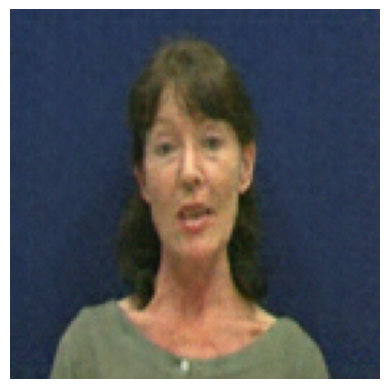

In [6]:
# create an empty folder for video path
data.gen_images(text="Hello, how are you",
                image_path="/ml/ml_proj_ex/DATASET/fadg0/video/sa1/001",
                video_path="/ml/ml_proj_ex/CODE/trial")